Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [8]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt

In [62]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
y = t[2].values

In [59]:
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [32]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [61]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
len(singles)

80

In [71]:
np.random.seed(1)
# rand_inds = np.random.choice(len(X), 100, replace=True) # generate random indices for 100 X's to sample from
train_seqs = [wt] + singles
train_inds = np.array([seq_to_x[seq] for seq in train_seqs])
X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

dic, _ = helpers.get_predictions(X_train, y_train, X_test, its=1000)

Iteration 1000 of 1000	NLML: 21.8973	sn: 0.527790	

In [66]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [75]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

np.random.seed(41950)
center = np.random.choice(len(ground), 35, replace=False)
center = [ground[c] for c in center]
chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, fn_args=(4, dic), g_args=(4, dic, 100))

TypeError: tuple indices must be integers or slices, not str

In [29]:
def seqs_from_set(chosen, L):
    pos = [[c[0] for c in chosen if c[1] == p] for p in range(L)]
    return [''.join(s) for s in itertools.product(*pos)]

seqs = seqs_from_set(chosen, 4)
X_sampled = [X_train]
y_sampled = [y_train]

In [74]:
type(dic[1])

list

In [ ]:
n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100

X_sampled = [X_train]
y_sampled = [y_train]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    dic, _ = helpers.get_predictions(np.concatenate(X_sampled), np.concatenate(y_sampled), X_test, its=500)
    print()
    best_loss = 0.0
    best_X = None
    best_h = None
    for i in range(max_its):
        np.random.seed(i)
        center = np.random.choice(len(ground), n_start, replace=False)
        center = [ground[c] for c in center]
        chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, 
                           fn_args=(L, dic), g_args=(L, dic, n), verbose=False)
        if h[-1] < best_loss:
            best_loss = h[-1]
            best_X = chosen
            best_h = h
    libraries.append(best_X)
    histories.append(best_h)
    seqs = seqs_from_set(best_X, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(X[inds])
    y_sampled.append(y[inds])
    
    

Round 0
Iteration 500 of 500	NLML: 22.5385	sn: 0.546728	


In [38]:
libraries

[[('S', 0),
  ('V', 1),
  ('K', 1),
  ('W', 1),
  ('L', 1),
  ('C', 1),
  ('H', 1),
  ('F', 1),
  ('M', 2),
  ('A', 2),
  ('L', 2),
  ('I', 2),
  ('S', 2),
  ('W', 3),
  ('S', 3),
  ('A', 3),
  ('F', 3)],
 [('S', 0),
  ('K', 1),
  ('W', 1),
  ('L', 1),
  ('F', 1),
  ('G', 2),
  ('A', 2),
  ('L', 2),
  ('I', 2),
  ('S', 2),
  ('R', 2),
  ('E', 3),
  ('W', 3),
  ('S', 3),
  ('A', 3),
  ('V', 3),
  ('F', 3)]]

In [40]:
histories

[[tensor(1.00000e-02 *
         -9.3992),
  tensor(-0.1110),
  tensor(-0.1701),
  tensor(-0.2016),
  tensor(-0.2016),
  tensor(-0.2430),
  tensor(-0.2539),
  tensor(-0.3358),
  tensor(-0.4526),
  tensor(-1.1469),
  tensor(-1.1469)],
 [tensor(-0.6281),
  tensor(-0.8328),
  tensor(-1.6080),
  tensor(-4.2984),
  tensor(-4.6877),
  tensor(-6.2220),
  tensor(-10.7436),
  tensor(-10.7436),
  tensor(-10.7436),
  tensor(-10.7436),
  tensor(-10.7436),
  tensor(-11.8298),
  tensor(-11.8298),
  tensor(-11.8298)]]

In [53]:
df = pd.DataFrame(np.concatenate(y_sampled), columns=['y'])
df['round'] = [0] * n + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,-2.966908,0
1,-3.640818,0
2,-3.385223,0
3,-5.000000,0
4,-5.000000,0


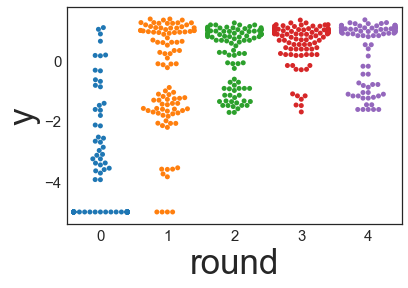

In [54]:
_ = sns.swarmplot(data=df, x='round', y='y')

In [55]:
[max(yy) for yy in y_sampled]

[1.0945012908976814,
 1.3787815543937225,
 1.249929473284833,
 1.3438411604430418,
 1.3513120244540753]

In [57]:
[opt.get_N(lib, L) for lib in libraries]

[162, 144, 108, 96]